In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [90]:
# Open data with wind
train = pd.read_csv('../../data/processed/train_with_wind.csv', sep=',')
test = pd.read_csv('../../data/processed/test_with_wind.csv', sep=',')

In [91]:
# Create dummy variables to recoginse the datasets
train['dataset'] = 'train'
test['dataset'] = 'test'

# Combine train and test based on the datetime column
data = pd.concat([train, test], axis=0)
data.sort_values('datetime', inplace=True)

#reset_index
data.reset_index(drop=True, inplace=True)

In [92]:
mask = data['dataset'] == 'train'

In [93]:
def smooth_data(data, features, window_sizes):
    for i, feature in enumerate(features):
        min_periods = int(np.ceil(window_sizes[i]/2))
        data[feature] = data[feature].rolling(window=window_sizes[i], min_periods= min_periods, center = True).mean()
    return data

# Smooth data
features = ['temp', 'atemp', 'humidity', 'windspeed']
window_sizes = [3, 3, 3, 3, 3, 3, 3, 3, 3]
data = smooth_data(data, features, window_sizes)

# Smooth train data
features = ['count', 'registered', 'casual']
window_sizes = [3, 3, 3]

ADF Statistic for count: -6.419975656501509
count is stationary



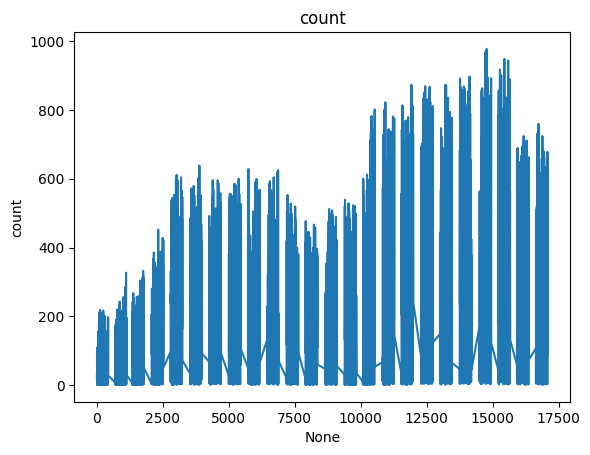

ADF Statistic for registered: -7.475669726156094
registered is stationary



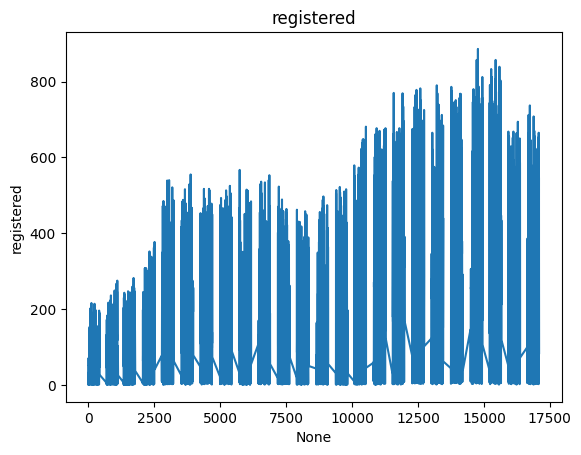

ADF Statistic for casual: -10.383742730117927
casual is stationary



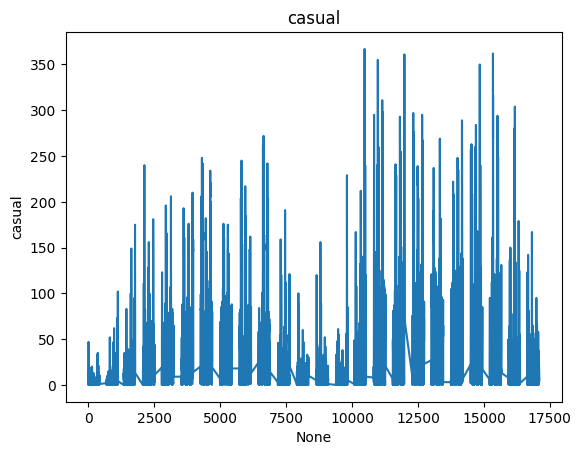

In [94]:
# check stationarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(dataset, columns):
    stationary_results = {}
    
    for col in columns:
        result = adfuller(dataset[col])
        print(f'ADF Statistic for {col}: {result[0]}')
        stationary_results[col] = {'ADF Statistic': result[0],
                                   'p-value': result[1],
                                   'Critical Values': result[4]}
        # Print weather the data is stationary or not
        if result[1] < 0.05:
            print(f'{col} is stationary\n')
        else:
            print(f'{col} is not stationary\n')

        # Plot data with seaborn with index as x
        sns.lineplot(data=dataset, x=dataset.index, y=col)
        plt.title(col)
        plt.show()
        
    return stationary_results

# Check stationarity
columns = ['count', 'registered', 'casual']
stationarity_results = check_stationarity(data[mask], columns)


In [95]:
data.isnull().sum()

datetime         0
season           0
holiday          0
workingday       0
weather          0
temp             0
atemp            0
humidity         0
windspeed        0
casual        6493
registered    6493
count         6493
year             0
month            0
day              0
hour             0
dataset          0
dtype: int64

In [96]:
def remove_outliers(data, features):

    # Create a new copied column for each feature
    for feature in features:
        data[f'{feature}_orig'] = data[feature].copy()

        # Calculate the z-score
        data[f'{feature}_zscore'] = np.abs((data[feature] - data[feature].mean())/data[feature].std())

        # Set to NaN values that are outliers
        data.loc[data[f'{feature}_zscore'] > 3, feature] = np.nan
        
    return data

# Remove outliers
features = ['count', 'registered', 'casual']
train = data[mask].copy()
data[mask] = remove_outliers(train, features)

In [97]:
def interpolate_outliers(data, features):
    for feature in features:
        data[feature] = data[feature].interpolate(method='spline', order=3)
    return data

# Interpolate outliers
train = data[mask].copy()
data[mask] = interpolate_outliers(train, features)

In [98]:
# convert datetime to datetime
data['datetime'] = pd.to_datetime(data['datetime'])

In [99]:
# Add day of the year number from 1 to 365
data['dayofyear'] = data['datetime'].dt.dayofyear

# Add week of the year number from 1 to 52
data['weekofyear'] = data['dayofyear'] // 7
# Add day of the week
data['dayofweek'] = data['datetime'].dt.dayofweek

In [100]:
data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dataset', 'dayofyear', 'weekofyear',
       'dayofweek'],
      dtype='object')

In [101]:
def create_lagged_features(data, features, lags):
    
    for feature in features:
        for lag in lags:

            current = data[feature]
            positive_lag = current.shift(lag)
            negative_lag = current.shift(-lag)

            mask_positive = positive_lag.isnull()
            mask_negative = negative_lag.isnull()
            mask_double = mask_positive & mask_negative

            #positive_lag[mask_positive & (~mask_double)] = current[mask_positive] + (current - negative_lag)[mask_positive]
            #negative_lag[mask_negative & (~mask_double)] = current[mask_negative] + (current - positive_lag)[mask_negative]

            data[f'{feature}, +{lag}'] = positive_lag
            data[f'{feature}, -{lag}'] = negative_lag
    return data

# Create lagged features
features = ['windspeed', 'atemp', 'humidity', 'holiday', 'workingday', 'weather', 'temp']
days_of_lag = [7]
lags = [day * 24 for day in days_of_lag]

data = create_lagged_features(data, features, lags)

features = ['casual', 'registered']
days_of_lag = [6, 7, 8]
lags = [day * 24 + i for day in days_of_lag for i in (-1, 0, 1)]
data = create_lagged_features(data, features, lags)

In [102]:
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,"registered, +168","registered, -168","registered, +169","registered, -169","registered, +191","registered, -191","registered, +192","registered, -192","registered, +193","registered, -193"
0,2011-01-01 00:00:00,1,0,0,1,9.430000,14.015000,80.500000,6.496104,3.0,...,18.0,8.0,11.0,15.0,25.0,1.0,21.0,5.0,16.0,10.0
1,2011-01-01 01:00:00,1,0,0,1,9.293333,13.888333,80.333333,6.492727,8.0,...,49.0,15.0,44.0,20.0,59.0,5.0,54.0,10.0,45.0,19.0
2,2011-01-01 02:00:00,1,0,0,1,9.293333,13.888333,78.333333,6.153690,5.0,...,34.0,20.0,-2.0,56.0,44.0,10.0,35.0,19.0,5.0,49.0
3,2011-01-01 03:00:00,1,0,0,1,9.566667,14.141667,76.666667,7.400227,3.0,...,-36.0,56.0,-40.0,60.0,1.0,19.0,-29.0,49.0,-27.0,47.0
4,2011-01-01 04:00:00,1,0,0,1,9.840000,13.890000,75.000000,7.239303,0.0,...,-58.0,60.0,-88.0,90.0,-47.0,49.0,-45.0,47.0,-77.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.660000,13.131667,56.000000,10.333633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.660000,12.880000,60.000000,11.001400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.660000,13.131667,58.666667,10.333633,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.660000,13.383333,60.333333,9.665867,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# make list of columns that are never nan from data.columns
columns = data.columns
mask = data.isnull().sum() == 0

columns_full = columns[mask]
columns_to_fill = columns[~mask]

# Remove 'casual' and 'registered' and 'count' from columns_to_fill
columns_to_fill = columns_to_fill[~columns_to_fill.isin(['casual', 'registered', 'count'])]

In [104]:
print(f'Columns that are never NaN: {columns}')
print(f'Columns that have NaN: {columns_to_fill}')
print('')
print(f'Number of columns to fill: {len(columns_to_fill)}')

Columns that are never NaN: Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dataset', 'dayofyear', 'weekofyear',
       'dayofweek', 'windspeed, +168', 'windspeed, -168', 'atemp, +168',
       'atemp, -168', 'humidity, +168', 'humidity, -168', 'holiday, +168',
       'holiday, -168', 'workingday, +168', 'workingday, -168',
       'weather, +168', 'weather, -168', 'temp, +168', 'temp, -168',
       'casual, +143', 'casual, -143', 'casual, +144', 'casual, -144',
       'casual, +145', 'casual, -145', 'casual, +167', 'casual, -167',
       'casual, +168', 'casual, -168', 'casual, +169', 'casual, -169',
       'casual, +191', 'casual, -191', 'casual, +192', 'casual, -192',
       'casual, +193', 'casual, -193', 'registered, +143', 'registered, -143',
       'registered, +144', 'registered, -144', 'registered, +145',
       'registered, -145', 'registere

In [ ]:
def drop_columns(data):
    """Drop unnecessary columns from the dataset."""
    columns_to_drop = ['datetime', 'dataset', 'day', 'month', 'year']
    return data.drop(columns=columns_to_drop)

def create_train_test_data(data, feature):
    
    # Identify missing values
    mask = data[feature].isnull()

    # Split the data into train and test sets
    X = data[~mask]
    X_pred = data[mask]
    X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=[feature]), X[feature], test_size=0.2, random_state=1)
    return X_train, X_test, y_train, y_test, X_pred

def create_and_fit_pipeline(X_train, y_train, max_iter):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor(max_iter=max_iter))
    ])
    pipeline.fit(X_train, y_train)
    return pipeline

def evaluate_pipeline(pipeline, X_test, y_test):
    """Evaluate the performance of the pipeline."""
    mae = np.mean(np.abs(pipeline.predict(X_test) - y_test))
    mse = np.mean((pipeline.predict(X_test) - y_test)**2)
    score = pipeline.score(X_test, y_test)
    return mae, mse, score

In [ ]:
def pipeline(data, feature, max_iter):
    data = drop_columns(data)
    X_train, X_test, y_train, y_test, X_pred = create_train_test_data(data, feature)
    pipeline = create_and_fit_pipeline(X_train, y_train, max_iter)
    mae, mse, score = evaluate_pipeline(pipeline, X_test, y_test)

    # Print the results on the same line
    print(f'MAE: {mae}, MSE: {mse}, Score: {score}')

    # Predict the missing values
    y_pred = pipeline.predict(X_pred)

    return y_pred, mae, mse, score

In [ ]:
def random_shuffles(data, n):
    """
    Randomly shuffles the columns of the given data and returns a list of orders to fill.

    Parameters:
    data (list): The data to shuffle.
    n (int): The number of shuffles to perform.

    Returns:
    list: A list of orders to fill, where each order is a shuffled list of columns.
    """
    orders_to_fill = []
    for i in range(n):
        shuffled_columns = columns_to_fill.copy()
        np.random.shuffle(shuffled_columns)
        orders_to_fill.append(shuffled_columns)

    return orders_to_fill


[array(['registered, -167', 'registered, +143', 'registered, -145',
       'casual, +191', 'casual, -143', 'registered, -193',
       'registered, +168', 'casual, +193', 'registered, -144',
       'casual, -167', 'casual, +144', 'casual, +167', 'casual, +168',
       'registered, +145', 'registered, +169', 'casual, -193',
       'casual, -144', 'casual, -168', 'registered, -143', 'casual, +145',
       'casual, -191', 'casual, -192', 'registered, -168',
       'registered, +192', 'registered, +167', 'casual, +192',
       'casual, -169', 'registered, +193', 'registered, -192',
       'casual, -145', 'registered, +191', 'casual, +143',
       'registered, -191', 'registered, -169', 'casual, +169',
       'registered, +144'], dtype=object), array(['registered, -145', 'registered, -144', 'registered, +169',
       'registered, +145', 'registered, -167', 'casual, +192',
       'casual, -168', 'casual, -145', 'casual, -167', 'casual, +144',
       'casual, +193', 'casual, -144', 'registered

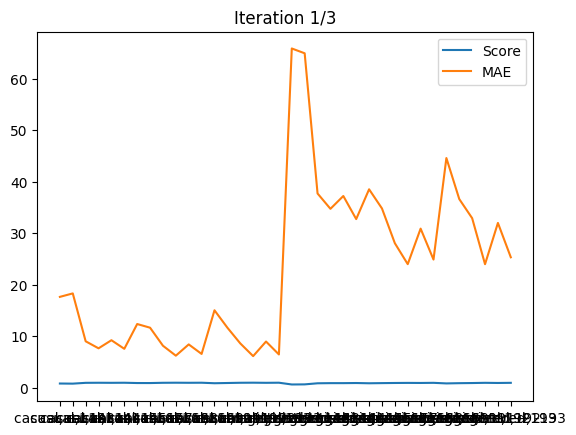

Iteration 2/3


ValueError: cannot reindex on an axis with duplicate labels

In [106]:
def stochastic_fill(data, columns_to_fill, columns_full, iterations, max_iter=1000):

    # Store original data
    original_data = data

    # Convert columns_to_fill to a mutable data structure
    columns_to_fill = np.array(columns_to_fill)

    # Store original order in a dictionary
    original_order = {columns_to_fill[i]: i for i in range(len(columns_to_fill))}

    

    # Store predictions in a np array in 3 dimensions
    predictions = np.zeros((len(data), len(columns_to_fill), iterations))

    # Store masks of missing data in a np array in 2 dimensions
    masks = data[columns_to_fill].isnull().values

    for i in range(iterations):
        print(f'Iteration {i+1}/{iterations}')

        data = original_data.copy()

        # Take the order of the columns to fill
        columns_order = orders_to_fill[i]

        maes = np.zeros(len(columns_to_fill))
        mses = np.zeros(len(columns_to_fill))
        scores = np.zeros(len(columns_to_fill))

        for feature in columns_to_fill:
            columns = list(columns_full) + [feature]
            mask = data[feature].isnull()

            y_pred, mae, mse, score = pipeline(data[columns], feature, max_iter)

            # Save the maes, mses and scores
            maes[original_order[feature]] = mae
            mses[original_order[feature]] = mse
            scores[original_order[feature]] = score
            
            # Fill the missing values
            data.loc[mask, feature] = y_pred

            # Add the feature to the columns_full
            columns_full = np.append(columns_full, feature)

            # Store the predictions
            predictions[:, original_order[feature], i] = data[feature]

        # plot scores, maes and mses for iteration i using seaborn as lineplot
        sns.lineplot(x=columns_to_fill, y=scores, label='Score')
        sns.lineplot(x=columns_to_fill, y=maes, label='MAE')
        plt.legend()
        plt.title(f'Iteration {i+1}/{iterations}')
        plt.show()

    # Take average value of the predictions for each feature
    predictions = np.mean(predictions, axis=2)
    
    # substitute the values in the original data
    data[columns_to_fill] = predictions

    return data
    
# Fill missing values
iterations = 3
max_iter = 2000
final_data = stochastic_fill(data, columns_to_fill, columns_full, iterations, max_iter)

In [ ]:
# save data
data.to_csv('../../data/processed/final_data.csv', index=False)